<a href="https://colab.research.google.com/github/cocobridge696/ML/blob/main/MV_Bitcoin_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from tqdm import tqdm_notebook as tqdm
import _pickle as pickle
plt.style.use('ggplot')

In [23]:
bc=pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1537574400&period2=1632268800&interval=1d&events=history&includeAdjustedClose=true')

# Convert to datetime (useful for plotting etc)
bc['Date'] = pd.to_datetime(bc.Date)
#set index as date
bc.set_index('Date',inplace=True)
bc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-22,6735.049805,6814.560059,6616.799805,6721.979980,6721.979980,4.509660e+09
2018-09-23,6715.319824,6766.149902,6679.419922,6710.629883,6710.629883,4.197500e+09
2018-09-24,6704.770020,6713.560059,6580.899902,6595.410156,6595.410156,4.177310e+09
2018-09-25,6603.640137,6603.640137,6381.859863,6446.470215,6446.470215,4.726180e+09
2018-09-26,6452.790039,6585.910156,6397.890137,6495.000000,6495.000000,4.437300e+09


# Make the data stationary:
 stationary process has the property that the mean, variance and autocorrelation structure do not change over time. Stationarity can be defined in precise mathematical terms, but for our purpose we mean a flat looking series, without trend, constant variance over time, a constant autocorrelation structure over time and no periodic fluctuations (seasonality). It improves prediction performance by removing seasonality and trends


convert to logs for lower p value (closer to stationary) 

In [24]:
bc_log=pd.DataFrame(np.log(bc)) #use closing price
bc_log_diff=bc_log.diff().dropna() #difference between successive values,drop nan values
print(bc_log.head())
print(bc_log_diff.head())


  


                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2018-09-22  8.815080  8.826817  8.797367  8.813138   8.813138  22.229488
2018-09-23  8.812147  8.819688  8.806786  8.811448   8.811448  22.157755
2018-09-24  8.810574  8.811885  8.791927  8.794129   8.794129  22.152933
2018-09-25  8.795376  8.795376  8.761215  8.771288   8.771288  22.276383
2018-09-26  8.772268  8.792688  8.763724  8.778788   8.778788  22.213312
                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2018-09-23 -0.002934 -0.007129  0.009419 -0.001690  -0.001690 -0.071733
2018-09-24 -0.001572 -0.007803 -0.014860 -0.017319  -0.017319 -0.004822
2018-09-25 -0.015198 -0.016508 -0.030712 -0.022841  -0.022841  0.123450
2018-09-26 -0.023108 -0.002688  0.002509  0.007500   0.007500 -0.063071
2018-09-27  0.006565  0.018979  0.010427  0.027599   0.02

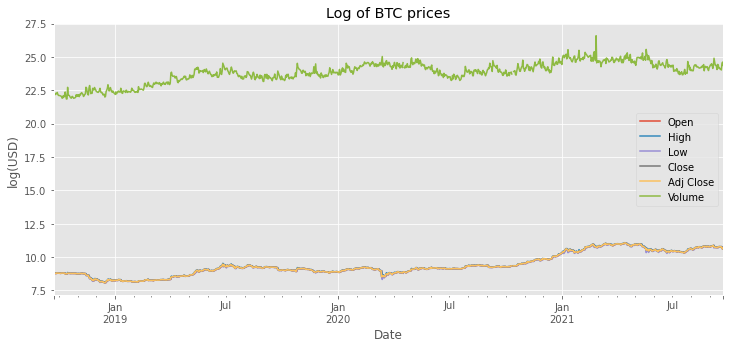

<Figure size 432x288 with 0 Axes>

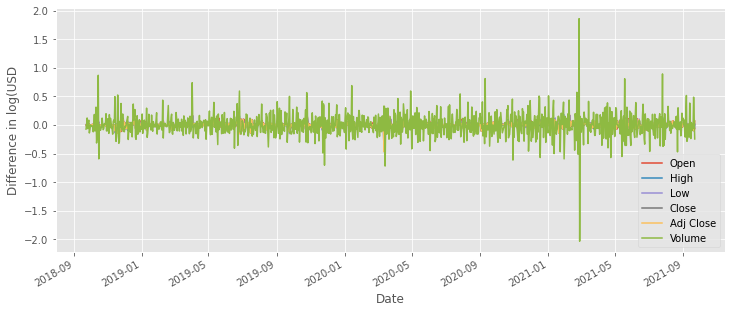

In [25]:
bc_log.plot(figsize=(12,5))
plt.title('Log of BTC prices')
plt.xlabel('Date')
plt.ylabel('log(USD)')

plt.figure()
bc_log_diff.plot(figsize=(12,5))
plt.xlabel('Date')
plt.ylabel('Difference in log(USD')
plt.show()

# LSTM model

In [26]:
#normalize data
norm_bc=(bc_log.dropna()-bc_log.dropna().mean())/bc_log.dropna().std()
print(norm_bc)


                Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2018-09-22 -0.700255 -0.710386 -0.697391 -0.704046  -0.704046 -2.023247
2018-09-23 -0.703796 -0.718947 -0.685931 -0.706084  -0.706084 -2.113929
2018-09-24 -0.705694 -0.728316 -0.704010 -0.726974  -0.726974 -2.120024
2018-09-25 -0.724041 -0.748138 -0.741375 -0.754526  -0.754526 -1.963964
2018-09-26 -0.751937 -0.751366 -0.738323 -0.745479  -0.745479 -2.043696
...              ...       ...       ...       ...        ...       ...
2021-09-18  1.652101  1.653273  1.690133  1.674146   1.674146  0.310811
2021-09-19  1.677254  1.641814  1.685798  1.648435   1.648435  0.237599
2021-09-20  1.651791  1.616703  1.568257  1.530095   1.530095  0.853874
2021-09-21  1.538063  1.518393  1.485193  1.467989   1.467989  0.984794
2021-09-22  1.470704  1.528566  1.510553  1.550494   1.550494  0.675776

[1093 rows x 6 columns]


In [27]:
#put in form of [all data points before for multiple chosen variables for as long back as chosen history size]

def format_data(dataset,label,start,end,history_size,target_size,single_step,step):
  data=[]
  labels=[]
  start=start+history_size
  if end is None:
    end=len(dataset)-target_size
  for i in range(start,end):
    indicies=[range(i-history_size,i,step)]
    data.append(dataset[indicies])
    if single_step:
      labels.append(label[i+target_size])
    else:
      labels.append(label[i:i+target_size])
  return np.array(data),np.array(labels)

In [28]:
#start off predicting a single day ahead using stationary data
history_size=20
index=3 #index of close
data,labels=format_data(norm_bc.values,norm_bc.values[:,3],0,None,history_size,0,True,1)

trainsplit=0.8

trainsplit=int(len(data)*trainsplit)
tr_labels=labels[0:trainsplit]
train=data[0:trainsplit]

test=data[trainsplit:]
te_labels=labels[trainsplit:]

print(train.shape,tr_labels.shape,test.shape,te_labels.shape)

(858, 20, 6) (858,) (215, 20, 6) (215,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


In [29]:
#lstm model

import tensorflow as tf

input_shape=train.shape[-2:] #=historysize,1

lstm_model=tf.keras.models.Sequential()
lstm_model.add(tf.keras.layers.LSTM(64,input_shape=input_shape))
lstm_model.add(tf.keras.layers.Dense(100,activation='relu'))
lstm_model.add(tf.keras.layers.Dense(36,activation='relu'))
lstm_model.add(tf.keras.layers.Dense(1))
lstm_model.compile(optimizer='adam',loss='mse')

In [30]:
#DNN model
model=tf.keras.models.Sequential([
                                  tf.keras.layers.Dense(100,activation='relu',input_shape=input_shape),
                                  tf.keras.layers.Dense(36,activation='relu'),
                                  tf.keras.layers.Dense(16,activation='relu'),
                                  tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam',loss='mse')

In [31]:
epochs=100



result=lstm_model.fit(x=train,y=tr_labels,epochs=epochs,validation_data=(test,te_labels))

Epoch 1/100
27/27 [==============================] - 3s 33ms/step - loss: 0.1139 - val_loss: 0.0677
Epoch 2/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 0.0456
Epoch 3/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0056 - val_loss: 0.0277
Epoch 4/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0050 - val_loss: 0.0212
Epoch 5/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0154
Epoch 6/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0049 - val_loss: 0.0234
Epoch 7/100
27/27 [==============================] - 0s 16ms/step - loss: 0.0042 - val_loss: 0.0124
Epoch 8/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0042 - val_loss: 0.0211
Epoch 9/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0040 - val_loss: 0.0157
Epoch 10/100
27/27 [==============================] - 0s 15ms/step - loss: 0.0044 - val_loss: 0.0104

In [32]:
result.history['val_loss'][-1]

0.004209622740745544

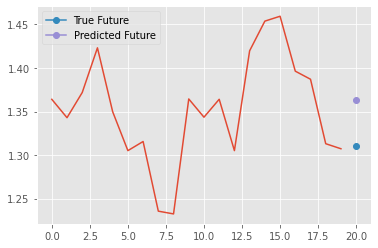

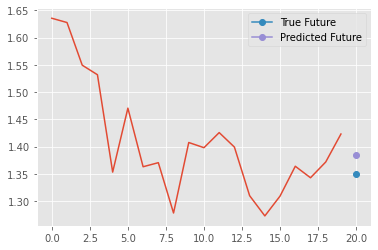

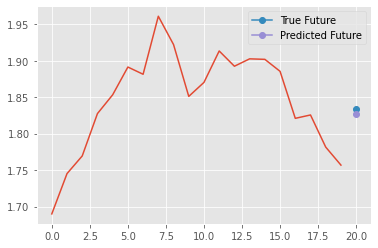

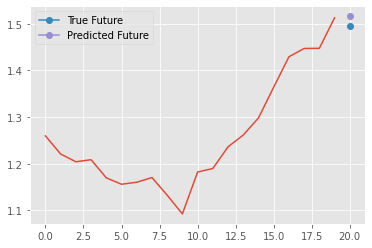

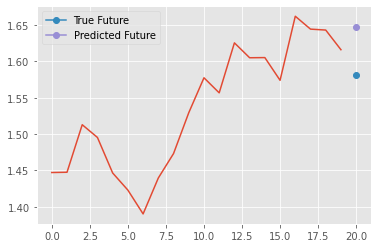

In [33]:
from random import randint
for y in range(5):
  x=randint(0,len(test)-1)
  plt.figure()
  plt.plot(test[x,:,3])
  plt.plot(history_size,te_labels[x],marker='o',label='True Future')
  plt.plot(history_size,lstm_model.predict(test[x].reshape(1,history_size,-1)),marker='o',label='Predicted Future')
  plt.legend()

The lstm model achieved a MSE of 0.0042 while the basline MSE was 0.0026


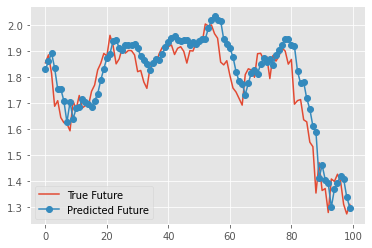

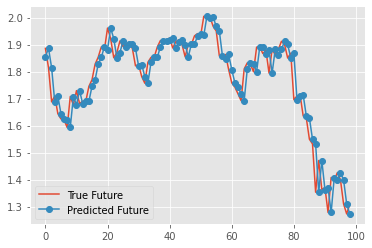

In [34]:
x=100
plt.plot(range(x),te_labels[0:x],label='True Future')
plt.plot(lstm_model.predict(test[:x]),marker='o',label='Predicted Future')
plt.legend()
plt.ylabel('')
plt.xlabel('')

lstm_mse=tf.keras.losses.MSE(te_labels.reshape(-1),lstm_model.predict(test).reshape(-1))

#compare with using just previous datapoint to predict future which can be considered a basline
plt.figure()
x=100
plt.plot(range(x-1),te_labels[1:x],label='True Future')
plt.plot(range(x-1),te_labels[:x-1],marker='o',label='Predicted Future')
plt.legend()
basline_mse=tf.keras.losses.MSE(te_labels[1:].reshape(-1),te_labels[:-1].reshape(-1))
numner=0.000505
print('The lstm model achieved a MSE of {:0.4f} while the basline MSE was {:0.4f}'.format(lstm_mse,basline_mse))

## Finding optimium history size

In [39]:
def opt_hist(norm_data,history_range,trainsplit,epochs):
  count=0
  final_loss=np.zeros([len(history_range),2])
  final_loss[:,0]=history_range
  for x in history_range:
    data,labels=format_data(norm_data,norm_data[:,3],0,None,x,0,True,1)
    train_split=int(len(data)*trainsplit)
    tr_labels=labels[0:train_split]
    train=data[0:train_split]
    test=data[train_split:]
    te_labels=labels[train_split:]
    #lstm model
    lstm_model=None
    import tensorflow as tf
    input_shape=train.shape[-2:] 
    lstm_model=tf.keras.models.Sequential()
    lstm_model.add(tf.keras.layers.LSTM(64,input_shape=input_shape))
    lstm_model.add(tf.keras.layers.Dense(100,activation='relu'))
    lstm_model.add(tf.keras.layers.Dense(36,activation='relu'))
    lstm_model.add(tf.keras.layers.Dense(1))
    lstm_model.compile(optimizer='adam',loss='mse')
    results=lstm_model.fit(x=train,y=tr_labels,epochs=epochs,validation_data=(test,te_labels),verbose=0)
    print(count)
    final_loss[count,1]=min(results.history['val_loss'])
    count+=1
  return final_loss


In [40]:
history_range=range(3,30,2)
epochs=100
trainsplit=0.8
params=opt_hist(norm_bc.values,history_range,trainsplit,epochs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  # This is added back by InteractiveShellApp.init_path()


0
1
2
3
4
5
6
7
8
9
10
11
12
13


In [41]:
min_loss=min(params[:,1])
opt_history=params[:,0][np.where(params[:,1]==min_loss)][0]
print('The lowest loss achieved was a MSE of {:0.4f} with a history size of {:0.4f}'.format(min_loss,opt_history))

The lowest loss achieved was a MSE of 0.0029 with a history size of 11.0000


In [42]:
print(params)

[[3.00000000e+00 3.95343639e-03]
 [5.00000000e+00 3.31503013e-03]
 [7.00000000e+00 3.01009417e-03]
 [9.00000000e+00 3.03186476e-03]
 [1.10000000e+01 2.94588204e-03]
 [1.30000000e+01 3.51167726e-03]
 [1.50000000e+01 3.70769342e-03]
 [1.70000000e+01 3.88417533e-03]
 [1.90000000e+01 3.59704206e-03]
 [2.10000000e+01 3.74397170e-03]
 [2.30000000e+01 3.88601120e-03]
 [2.50000000e+01 3.60865914e-03]
 [2.70000000e+01 4.14811028e-03]
 [2.90000000e+01 3.97386402e-03]]
